# Counting dice

## Fine-tuning an object detection model

![](https://upload.wikimedia.org/wikipedia/commons/thumb/3/36/Two_red_dice_01.svg/671px-Two_red_dice_01.svg.png)

## SageMaker Ground-Truth

You'll shortly step through the process of setting up a SageMaker ground-truth labelling job, but first we need to upload our images to Amazon S3.

We have already loaded the images onto this SageMaker Notebook instance, and you can find them at `./data`.

Using the Amazon SageMaker SDK we can upload these images to the default bucket. See `session.upload_data` below.

In [1]:
import sagemaker

session = sagemaker.session.Session()
default_s3_bucket = 's3://{}'.format(session.default_bucket())
print('default_s3_bucket: {}'.format(default_s3_bucket))

default_s3_bucket: s3://sagemaker-us-east-2-412868550678


In [51]:
training_images = session.upload_data('./data', key_prefix='vegas-dice-images')

You should now open the [AWS Management Console](https://console.aws.amazon.com/sagemaker/groundtruth?region=us-east-1#/labeling-jobs) and setup your SageMaker ground-truth labeling job.

In [50]:
print("Bucket for ground-truth Labeling: {}/images/".format(training_images))

Bucket for Ground Truth Labeling: s3://sagemaker-us-east-2-412868550678/vegas-dice-images/images/


## Exploritory Data Analysis

In this section we are going to download and explore the data. This is a dataset that has been labeled in ground-truth and contains the bounding boxes for the dice present in the picture from the training dataset

It is recommended at the beginning of any ML project to get well acquainted with the format and type of data that you are working with, on a qualitative and quantitative level

In [3]:
!pip install gluoncv --pre -q

You are using pip version 10.0.1, however version 19.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [4]:
import glob
import json
import math
import os
import random
import time
import zipfile

import cv2
import gluoncv as gcv
import matplotlib.pyplot as plt
import mxnet as mx
import numpy as np

### Visualize the images

In [5]:
data_dir = 'data'
images_dir = os.path.join(data_dir, 'images')
train_images = glob.glob(images_dir + "/*")

In [6]:
print("We have {} images".format(len(train_images)))

We have 315 images


Let's see how they look like. We use matplotlib to plot 36 images from the dataset to get a feel for what they are

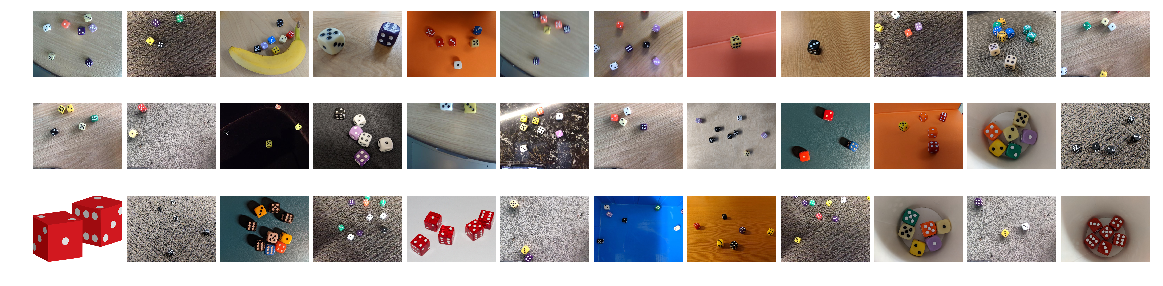

In [7]:
n_images = 36
cols = (int(math.sqrt(n_images)))*2
fig = plt.figure(figsize=(20,5))
for n, (image) in enumerate(train_images[:n_images]):
    image = plt.imread(image)
    a = fig.add_subplot(np.ceil(n_images/float(cols)), cols, n + 1)
    plt.imshow(image)
    plt.axis('off')
plt.subplots_adjust(wspace=0.06, hspace=0.06)
plt.show()

### Bounding boxes

We've included the `output.manifest` file from our complete SageMaker GroundTruth labeling job on all images.

Let's dig in the info we have in the manifest file! On each image, there is one or more dice. We read this information from the `output.manifest` file.

In [8]:
image_info = []
with open(os.path.join(data_dir, 'manifest', 'output.manifest')) as f:
    lines = f.readlines()
    for line in lines:
        image_info.append(json.loads(line[:-1]))

For each image, we have the following information:

In [9]:
info = image_info[10]
task = 'dice-labeling'
info

{'source-ref': 's3://tdelteil-sagemaker-reinvent2019-worksop/dice/IMG_20191112_101245_1.jpg',
 'dice-labeling': {'annotations': [{'class_id': 3,
    'width': 61,
    'top': 72,
    'height': 63,
    'left': 230},
   {'class_id': 3, 'width': 69, 'top': 116, 'height': 65, 'left': 419},
   {'class_id': 4, 'width': 54, 'top': 16, 'height': 60, 'left': 133},
   {'class_id': 4, 'width': 54, 'top': 21, 'height': 57, 'left': 38},
   {'class_id': 5, 'width': 68, 'top': 166, 'height': 69, 'left': 105}],
  'image_size': [{'width': 512, 'depth': 3, 'height': 384}]},
 'dice-labeling-metadata': {'job-name': 'labeling-job/dice-labeling',
  'class-map': {'1': 'two',
   '0': 'one',
   '3': 'four',
   '2': 'three',
   '5': 'six',
   '4': 'five',
   '6': 'unclear'},
  'human-annotated': 'yes',
  'objects': [{'confidence': 0.09},
   {'confidence': 0.09},
   {'confidence': 0.09},
   {'confidence': 0.09},
   {'confidence': 0.09}],
  'creation-date': '2019-11-12T22:03:36.489415',
  'type': 'groundtruth/objec

We can access the name of the different classes corresponding to the class index as given by the SageMaker ground-truth labeling job

In [10]:
class_map = info[task+'-metadata']['class-map']
classes = [class_map[str(i)] for i in range(len(class_map))]
classes

['one', 'two', 'three', 'four', 'five', 'six', 'unclear']

We can read the data from this dictionnary to use it to draw a bounding box around the dice using the OpenCV library

In [11]:
image = plt.imread(os.path.join(images_dir, info['source-ref'].split('/')[-1]))

In [12]:
boxes = info['dice-labeling']['annotations']
for box in boxes:
    cv2.rectangle(image, (int(box['left']), int(box['top'])), (int(box['left']+box['width']), int(box['top']+box['height'])), (0,255,0), 3)
    cv2.putText(image, str(box['class_id']+1), (int(box['left']+box['width']), int(box['top']+box['height'])), 1, 3, (255,0,0), 3)

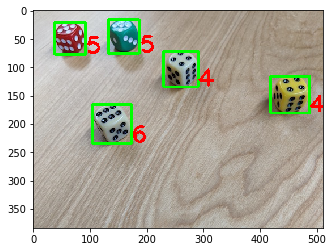

In [13]:
o = plt.imshow(image)

## Fine-tuning an object detection model

Now that we have explored the dataset, let's run a training job on SageMaker

In [14]:
import glob
import os
import re
import subprocess
import sys
import time
from time import gmtime, strftime

import boto3
import sagemaker
import numpy as np
from utils import get_execution_role

The training script used to train the model:

In [15]:
!pygmentize src/train_yolo.py

import argparse
import glob
import json
import math
import os
import random
import subprocess
import time
import zipfile

try:
    subprocess.run(["python", "-m", "pip", "install", "opencv-python"])
    subprocess.run(["python", "-m", "pip", "install", "gluoncv", "--pre"])
    import cv2    
    import gluoncv as gcv
    from gluoncv.utils import viz
    from gluoncv.data.batchify import Tuple, Stack, Pad
    from gluoncv.utils.metrics.voc_detection import VOC07MApMetric
    from gluoncv.data.batchify import Tuple, Stack, Pad
    from gluoncv.data.transforms.presets.yolo import YOLO3DefaultTrainTransform
    from gluoncv.data.transforms.presets.yolo import YOLO3DefaultValTransform
except:
    print("Cannot install dependencies")
        

import mxnet as mx
from mxnet import gluon, nd, autograd
import numpy as np

class GroundTruthDetectionDataset(gluon.data.Dataset):
    """
    Custom Dataset to handle the GroundTruthDetectionDataset
    """
    def __init__(self, data_path='data', s

We obtain the default sagemaker bucket, and upload the training images and manifest to that bucket

In [16]:
sage_session = sagemaker.session.Session()
s3_bucket = sage_session.default_bucket()  
s3_output_path = 's3://{}/'.format(s3_bucket)
print("S3 bucket path: {}".format(s3_output_path))

S3 bucket path: s3://sagemaker-us-east-2-412868550678/


Configuring the environment

1) It is always a good practice to run first the training job in local model in order to make sure that the training complete successfully, this allows much faster feedback cycle than waiting for the creation of remote instances

2) After running in local_mode = True, try with local_mode = False and run the hyper-parameter tuning job!

In [40]:
# run in local_mode on this machine, or as a SageMaker TrainingJob?
local_mode = True

if local_mode:
    instance_type = 'local' if mx.context.num_gpus() == 0 else 'local_gpu'
else:
    # If on SageMaker, pick the instance type
    instance_type = "ml.p3.2xlarge"

In [41]:
try:
    role = sagemaker.get_execution_role()
except:
    role = get_execution_role()

print("Using IAM role arn: {}".format(role))

Using IAM role arn: arn:aws:iam::412868550678:role/service-role/AmazonSageMaker-ExecutionRole-20191010T115893


In [42]:
# only run from SageMaker notebook instance
if local_mode:
    !/bin/bash ./setup.sh

### Metric

We define the metric that we are going to track, we want to track:
- the current running validation Mean Average Precision: `run_validation_mAP`
- the final best validation Mean Average Precision: `validation_mAP`

In [43]:
metric_definitions = [
    {'Name': 'validation_mAP', 'Regex': 'best mAP ([-+]?[0-9]*[.]?[0-9]+([eE][-+]?[0-9]+)?)'},
    {'Name': 'run_validation_mAP', 'Regex': 'running mAP ([-+]?[0-9]*[.]?[0-9]+([eE][-+]?[0-9]+)?)'}]

### Job definition

In [44]:
# create a descriptive job name 
job_name_prefix = 'hpo-dice-yolo'
max_jobs = 6
max_parallel_jobs = 2

In [45]:
from sagemaker.tuner import IntegerParameter, CategoricalParameter, ContinuousParameter, HyperparameterTuner
from sagemaker.mxnet.estimator import MXNet

Hyperparameters

In [46]:
static_hyperparameters = {
    'epochs': 2 if local_mode else 40
}

### Estimator

In [47]:
estimator = MXNet(entry_point="src/train_yolo.py",
                  role=role,
                  train_instance_type=instance_type,
                  train_instance_count=1,
                  output_path=s3_output_path,
                  framework_version="1.4.1",
                  py_version='py3',
                  base_job_name=job_name_prefix,
                  metric_definitions=metric_definitions,
                  hyperparameters=static_hyperparameters
                 )

Let's first run in local mode, then we can go back and switch it to remote mode

In [48]:
if local_mode:
    estimator.fit({"train": training_images})

In [49]:
assert not local_mode, "You need to go back up and modify local_mode to be False, and re-run all the cells until here"

### Hyperparameter Tuner job

We are going to run an hyper-parameter tuning job, it is using gaussian processes to estimate the best combination of parameters. Try picking some ranges based on what you know of ML and let the system finds the best candidates for you

In [ ]:
# The hyperparameters we're going to tune
hyperparameter_ranges = {
    'lr': ContinuousParameter(0.0001, 0.1), # learning rate, how much should the model learn from the current iteration ( < 0.01 )
    'batch_size': IntegerParameter(1, 10), # batch size, how many pictures in each learning iteration (> 1)
    'lr_factor': ContinuousParameter(0.1, 1), # learning rate factor, How much to multiply the learning rate after 2/3 of trainign (0 < x < 1)
    'wd': ContinuousParameter(0.0000001, 0.0001), # Weight decay: Regularization to force small weights ( < 0.001 )
    'class_factor': ContinuousParameter(1, 30), # Class factor: How much to weigh the importance of getting the right class vs finding objects (> 1)
    'model': CategoricalParameter(["yolo3_darknet53_coco", "yolo3_mobilenet1.0_coco"]),
}

In [ ]:
tuner = HyperparameterTuner(estimator,
                            objective_metric_name='validation_mAP',
                            objective_type='Maximize',
                            hyperparameter_ranges=hyperparameter_ranges,
                            metric_definitions=metric_definitions,
                            max_jobs=max_jobs,
                            max_parallel_jobs=max_parallel_jobs,
                            base_tuning_job_name=job_name_prefix
                           )
tuner.fit({"train":training_images})

In [ ]:
job_name = tuner.latest_tuning_job.job_name
print("Tuning job: %s" % job_name)

You can monitor the progress of your jobs here: https://us-east-1.console.aws.amazon.com/sagemaker/home?region=us-east-1#/hyper-tuning-jobs

## Deployment

Deploy the best tuning job

In [ ]:
estimator_best_job = estimator.attach(tuner.best_training_job(), sage_session)

We deploy the best tuning job on a cluster of one CPU instance

In [ ]:
deployed_model = estimator_best_job.deploy(1, 'ml.c5.4xlarge')

Predict bounding boxes

In [ ]:
x, image = gcv.data.transforms.presets.yolo.load_test('test.jpg', short=384)
output = deployed_model.predict(image)

Visualize the result

In [ ]:
cid = np.array(output['cid'])
scores = np.array(output['score'])
bbox = np.array(output['bbox'])


o = gcv.utils.viz.plot_bbox(image, bbox, scores, cid, class_names=classes)

## Running inference with the webcam

We are going to process the images from the browser, to the endpoint and back

This **ONLY** works in Jupyter Notebook **NOT** in Jupyter Labs


1) START: Capture an image in javascript through the webcam in the browse

2) Convert that image to base64 and send it over to the python kernel

3) Convert the image back to numpy and send it over to the SageMaker endpoint

4) Get the predicted bounding boxes and paint them over the numpy image

5) Convert the annoted image back to base64 and send it to the javascript

6) Display the annoted frame

7) GOTO START

In [ ]:
import base64
from io import BytesIO
from PIL import Image

def get_annotated_image(input_image_b64):
    prefix, input_image_b64 = input_image_b64.split(',')
    input_image_binary = io.BytesIO(b64decode(input_image_b64))
    input_image_np = np.asarray(Image.open(input_image_binary))
    _, input_image_loaded = gcv.data.transforms.presets.yolo.transform_test(mx.nd.array(input_image_np), short=384)
    output = deployed_model.predict(input_image_loaded)
    cid = np.array(output['cid'])
    scores = np.array(output['score'])
    bbox = np.array(output['bbox'])
    output_image_np = gcv.utils.viz.cv_plot_bbox(input_image_loaded, bbox, scores, cid, class_names=classes)
    output_image_PIL = Image.fromarray(output_image_np)
    output_buffer = BytesIO()
    output_image_PIL.save(output_buffer, format="JPEG")
    output_image_b64 = 'data:image/jpeg;base64,'+base64.b64encode(output_buffer.getvalue()).decode("utf-8")
    print(output_image_b64)

show_webcam()
#display()

## Compilation

We can compile the model for faster runtime on specific platforms, in the cloud or on the edge

In [ ]:
compiled_model = estimator_best_job.compile_model('ml_c5', {'data' : (1, 3, 384, 512)}, s3_output_path, framework='mxnet', framework_version='1.4.1')